In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import quantum as qm
import asymmetric as asym
import scipy.sparse.linalg as spla
import importlib
importlib.reload(asym)
from scipy.special import  comb

# Block Diagonal

In [88]:
L = 8; end = 20; n = 3; field_strength = 1

_,x_list,y_list, z_list = qm.get_sigma_lists(L, half=False)
H = asym.dense_H(L)
Z0 = z_list[0]
if (not field_strength is None):
    h = field_strength/2 # Take into account spin-1/2
    H = H + qm.get_local_field(z_list, np.random.rand(L)*2*h - h)

In [63]:
Hlist  = asym.mat2list(H)
Zlists = [asym.mat2list(Z) for Z in z_list]
Z0list = Zlists[0]
ZLlist = Zlists[L-1]

In [66]:
end = 20; n = 3; tot = n*end
OTOCs = asym.zotoc_mat_exact(L, Hlist, Zlists, end, n, fore=True)

/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


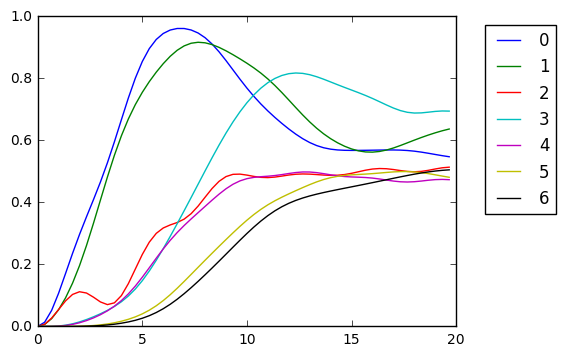

In [67]:
ax = plt.subplot(111)
for i in range(L):
    ax.plot(np.arange(tot)/n, OTOCs[i], label = str(i))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
# plt.ylim(0,1)
plt.show()

# expm_mult, vectors

In [63]:
vec = qm.get_vec_Haar(2**L)
vecs = asym.arr2list(vec)

In [86]:
OTOCs = asym.zotoc_vec_expm(L, Hlist, vecs, Zlists, end=20, n=3, fore=False)

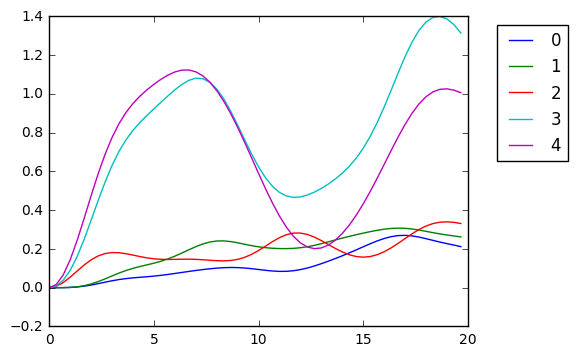

In [87]:
ax = plt.subplot(111)
for i in range(L):
    ax.plot(np.arange(tot)/n, OTOCs[i], label = str(i))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
# plt.ylim(0,1)
plt.show()

# Hybrid Method

In [29]:
cutoff = 20
s_Hlist  =  [H for H in Hlist  if H.shape[0]<cutoff]
s_Zlists = [[Z for Z in z_list if Z.shape[0]<cutoff] for z_list in Zlists]
s_Z0list =  [Z for Z in Z0list if Z.shape[0]<cutoff]

l_Hlist  =  [H for H in Hlist  if H.shape[0]>=cutoff]
l_Zlists = [[Z for Z in z_list if Z.shape[0]>=cutoff] for z_list in Zlists]
l_Z0list =  [Z for Z in Z0list if Z.shape[0]>=cutoff]
l_vecs  =   [v for v in vecs   if len(v)>=cutoff]

In [31]:
OTOCs = zotoc_mat_exact(L, s_Hlist, s_Z0list, s_Zlists, end=20, n=3) + \
        zotoc_vec_expm( L, l_Hlist, l_Z0list, l_vecs, l_Zlists)

/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


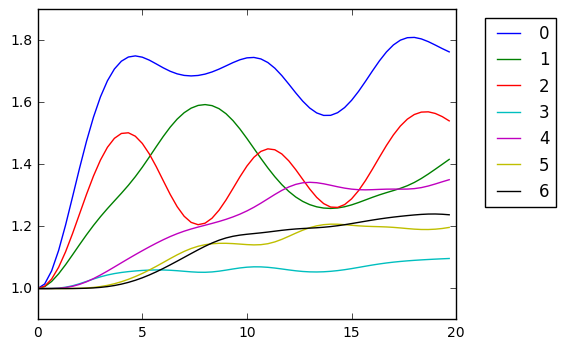

In [32]:
ax = plt.subplot(111)
for i in range(L):
    ax.plot(np.arange(tot)/n, OTOCs[i], label = str(i))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
# plt.ylim(0,1)
plt.show()

# Standard Errors

In [8]:
def zotoc_vec_std(Hlist, vecs, Zlists, sites, t):
    e = spla.expm_multiply
    L = len(sites)
    Z0list = Zlists[0]
    vbs  = [e(1j*H*t, Z0@e(-1j*H*t, vec)) for (H, Z0, vec) in zip(Hlist, Z0list, vecs)]

    OTOCs = np.zeros((L, L+1))
    for idx, site in enumerate(sites):
        v1s = [e(1j*H*t, Z0@e(-1j*H*t, Zi@vec)) for (H, Z0, vec, Zi) in zip(Hlist, Z0list, vecs, Zlists[site])]
        v2s = [Zi@vb for (Zi, vb) in zip(Zlists[site], vbs)]
        OTOCs[idx] = [(v2.conj().T@v1).real for (v1, v2) in zip(v1s, v2s)]
    return OTOCs

In [24]:
L = 12
_,_,_, z_list = qm.get_sigma_lists(L, half=False)
H = asym.dense_H(L)
h = .1
H = H + qm.get_local_field(z_list, np.random.rand(L)*2*h - h)

Hlist  = asym.mat2list(H)
Zlists = [asym.mat2list(Z) for Z in z_list]

In [28]:
nvecs = 5
sites = np.arange(L)
t = 20
OTOCss = np.zeros((nvecs,L,L+1))
for i in range(nvecs):
    vec = qm.get_vec_Haar(2**L)
    vecs = asym.arr2list(vec)
    OTOCss[i] = zotoc_vec_std(Hlist, vecs, Zlists, sites, t)

In [29]:
_, std = qm.mean_and_std(OTOCss)
np.shape(std)

(12, 13)

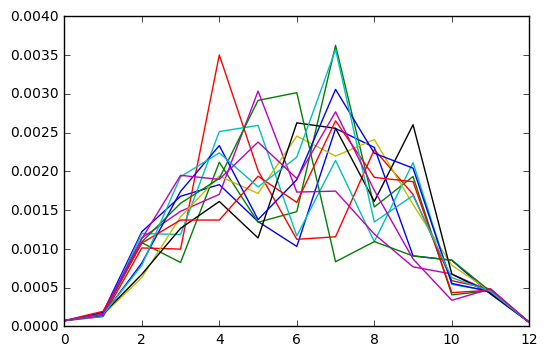

In [30]:
for i in range(L):
    plt.plot(std[i])
plt.show()

In [31]:
Z0t = spla.expm(2j*H)*z_list[0]*spla.expm(-2j*H)
B = x_list[2]
comm = Z0t*B - B*Z0t
-(comm*comm).diagonal().sum()/2**(L+2)

/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/cstahl/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


KeyboardInterrupt: 

In [5]:
L = 15
for i in range(L):
    print((int)(comb(L,i)))

1
15
105
455
1365
3003
5005
6435
6435
5005
3003
1365
455
105
15


In [7]:
[1, 2, 1j].real

AttributeError: 'list' object has no attribute 'real'